# Automatic Image Description Generator Project
By: Yeshvendra Kumar Singh

Description: In today's digital age, the ability to understand and describe images automatically has become increasingly valuable. Image captioning, a subfield of computer vision and natural language processing, aims to bridge the gap between visual content and human-readable text. This project leverages Python and machine learning techniques to create an image captioning system that takes an image as input and generates a descriptive sentence about its content.

In [1]:
# Importing all the modules which will be needed for this project

import numpy as np
import pandas as pd
import os
import tensorflow as tf
from keras_preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.models import Model
from keras.layers import Flatten, Dense, LSTM, Dropout, Embedding, Activation
from keras.layers import concatenate, BatchNormalization, Input
from keras.layers import add
from keras.utils import to_categorical
from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras.utils import plot_model
import matplotlib.pyplot as plt
import cv2
import string
import time

In [2]:
print("Starting the preprocessing part...")

# Reading the image description which are there in the training set.

token_path = 'dataset/Flickr_Data/Flickr_TextData/Flickr8k.token.txt'
text = open(token_path, 'r', encoding = 'utf-8').read()
print(text[:500])

Starting the preprocessing part...
1000268201_693b08cb0e.jpg#0	A child in a pink dress is climbing up a set of stairs in an entry way .
1000268201_693b08cb0e.jpg#1	A girl going into a wooden building .
1000268201_693b08cb0e.jpg#2	A little girl climbing into a wooden playhouse .
1000268201_693b08cb0e.jpg#3	A little girl climbing the stairs to her playhouse .
1000268201_693b08cb0e.jpg#4	A little girl in a pink dress going into a wooden cabin .
1001773457_577c3a7d70.jpg#0	A black dog and a spotted dog are fighting
1001773457_577c3a7


In [4]:
# Creating a dictionary where image name or id is the key and coresponding description are the list of values

def load_description(text):
    mapping = dict()
    for line in text.split("\n"):
        token = line.split("\t")
        if len(line) < 2:
            continue
        img_id = token[0].split('.')[0]
        img_des = token[1]
        if img_id not in mapping:
            mapping[img_id] = list()
        mapping[img_id].append(img_des)
    return mapping

descriptions = load_description(text)
print("Number of images: " + str(len(descriptions)))

print("\nSample RAW value:-")
print("Key: 2425262733_afe0718276")
print("Value: ")
print(descriptions['2425262733_afe0718276'])

Number of images: 8092

Sample RAW value:-
Key: 2425262733_afe0718276
Value: 
['A kid wearing a brown hoodie doing an ollie .', 'A man in a hoodie skateboards in front of a blue sky and building , shot from below .', 'A skateboarder jumps midair near a building .', 'A skateboarder making a jump .', 'Man with jeans and a hooding doing skateboarding tricks .']


In [5]:
# Preprocessing the description of images to remove puntuations, etc.

def clean_description(desc):
    for key, des_list in desc.items():
        for i in range(len(des_list)):
            caption = des_list[i]
            caption = [ch for ch in caption if ch not in string.punctuation]
            caption = ''.join(caption)
            caption = caption.split(' ')
            caption = [word.lower() for word in caption if len(word)>1 and word.isalpha()]
            caption = ' '.join(caption)
            des_list[i] = caption

clean_description(descriptions)

print("Sample value after cleaning:-")
print("Key: 2425262733_afe0718276")
print("Value: ")
print(descriptions['2425262733_afe0718276'])

Sample value after cleaning:-
Key: 2425262733_afe0718276
Value: 
['kid wearing brown hoodie doing an ollie', 'man in hoodie skateboards in front of blue sky and building shot from below', 'skateboarder jumps midair near building', 'skateboarder making jump', 'man with jeans and hooding doing skateboarding tricks']


In [7]:
# Create vocabulary from the description which was cleaned in previous step

def to_vocab(desc):
    words = set()
    for key in desc.keys():
        for line in desc[key]:
            words.update(line.split())
    return words

vocab = to_vocab(descriptions)

print("Length of vocabulary: " + str(len(vocab)))

Length of vocabulary: 8763


In [8]:
# Create list of images in the dataset

import glob
images = 'dataset/Flickr_Data/Images/'
# Create a list of all image names in the directory
img = glob.glob(images + '*.jpg')

print("Total number of images: " + str(len(img)))

Total number of images: 8091


In [9]:
# Reading already created training datapoints

train_path = 'dataset/Flickr_Data/Flickr_TextData/Flickr_8k.trainImages.txt'
train_images = open(train_path, 'r', encoding = 'utf-8').read().split("\n")
train_img = []

for im in img:
    if(im[len(images):] in train_images):
        train_img.append(im)

print("Total number of training datapoints: " + str(len(train_img)))

Total number of training datapoints: 6000


In [10]:
# Reading already created testing datapoints

test_path = 'dataset/Flickr_Data/Flickr_TextData/Flickr_8k.testImages.txt'
test_images = open(test_path, 'r', encoding = 'utf-8').read().split("\n")
test_img = []

for im in img:
    if(im[len(images): ] in test_images):
        test_img.append(im)

print("Total number of training datapoints: " + str(len(test_img)))

Total number of training datapoints: 1000


In [11]:
# Initializing the training and testing description

def load_clean_descriptions(des, dataset):
    dataset_des = dict()
    for key, des_list in des.items():
        if key + '.jpg' in dataset:
            if key not in dataset_des:
                dataset_des[key] = list()
            for line in des_list:
                desc = 'startseq ' + line + ' endseq'
                dataset_des[key].append(desc)
    return dataset_des

train_descriptions = load_clean_descriptions(descriptions, train_images)
print('Total training data = %d' % len(train_descriptions))

test_descriptions = load_clean_descriptions(descriptions, test_images)
print('Total testing data = %d' % len(test_descriptions))

Total training data = 6000
Total testing data = 1000


In [12]:
# Preprocess the images

from keras_preprocessing.image import load_img, img_to_array

# Function to preprocess the images which are used
def preprocess_img(img_path):
    #inception v3 excepts img in 299*299
    img = load_img(img_path, target_size = (299, 299))
    x = img_to_array(img)
    # Add one more dimension
    x = np.expand_dims(x, axis = 0)
    x = preprocess_input(x)
    return x

base_model = InceptionV3(weights = 'imagenet')
base_model.summary()

modelfirst = Model(base_model.input, base_model.layers[-2].output)

# Function to encode an image into a vector using inception v3
def encode(image):
    image = preprocess_img(image)
    vec = modelfirst.predict(image)
    vec = np.reshape(vec, (vec.shape[1]))
    return vec

# Run the encode function on all train images
start = time.time()
encoding_train = {}
for img in train_img:
    encoding_train[img[len(images):]] = encode(img)
print("Time Taken to encode training set is: " + str(time.time() - start))

# Run the encode function on all test images
start = time.time()
encoding_test = {}
for img in test_img:
    encoding_test[img[len(images):]] = encode(img)
print("Time taken to encode testing set is: " + str(time.time() - start))

train_features = encoding_train
test_features = encoding_test

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 149, 149, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 149, 149, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                      

In [13]:
# Use Datagenerator to pad sequence

# List of all training captions
all_train_captions = []
for key, val in train_descriptions.items():
    for caption in val:
        all_train_captions.append(caption)
print("Total number of training captions: " + str(len(all_train_captions)))

# Consider only words which occur atleast 10 times
vocabulary = vocab
threshold = 10
word_counts = {}
for cap in all_train_captions:
    for word in cap.split(' '):
        word_counts[word] = word_counts.get(word, 0) + 1

vocab = [word for word in word_counts if word_counts[word] >= threshold]
print("Unique words: " + str(len(word_counts)))
print("our Vocabulary: " + str(len(vocab)))

# Word mapping to integers
ixtoword = {}
wordtoix = {}

ix = 1
for word in vocab:
    wordtoix[word] = ix
    ixtoword[ix] = word
    ix += 1

np.save('Vocabulary.npy',vocab)
np.save('ixtoword.npy',ixtoword)
np.save('wordtoix.npy',wordtoix)

vocab_size = len(ixtoword) + 1  #1 for appended zeros
print("Our vocabulary size: " + str(vocab_size))

Total number of training captions: 30000
Unique words: 7578
our Vocabulary: 1651
Our vocabulary size: 1652


In [14]:
# Find the maximum length of a description in a dataset

max_length = max(len(des.split()) for des in all_train_captions)
print("Maximum length of caption in training set: " + str(max_length))

Maximum length of caption in training set: 34


In [15]:
# Preparing training data for LSTM to work on by forming in-sequence and out-sequence

X1, X2, y = list(), list(), list()
for key, des_list in train_descriptions.items():
    pic = train_features[key + '.jpg']
    for cap in des_list:
        seq = [wordtoix[word] for word in cap.split(' ') if word in wordtoix]
        for i in range(1, len(seq)):
            in_seq, out_seq = seq[:i], seq[i]
            in_seq = pad_sequences([in_seq], maxlen = max_length)[0]
            out_seq = to_categorical([out_seq], num_classes = vocab_size)[0]
            X1.append(pic)
            X2.append(in_seq)
            y.append(out_seq)

X2 = np.array(X2) # In-Sequence
X1 = np.array(X1) # Image Name
y = np.array(y) # Out-Sequence
print("Shape of image data: " + str(X1.shape))
print("Shape of in-sequence: " + str(X2.shape))
print("Shape of out-sequence: " + str(y.shape))

Shape of image data: (292328, 2048)
Shape of in-sequence: (292328, 34)
Shape of out-sequence: (292328, 1652)


In [19]:
# Read word embedding from stanfords glove vector.

embeddings_index = {}
glove = open('dataset/glove.6B/glove.6B.200d.txt', 'r', encoding = 'utf-8').read()
for line in glove.split("\n"):
    values = line.split(" ")
    word = values[0]
#     print("values: ",values)
    indices = np.asarray(values[1: ], dtype = 'float32')
    embeddings_index[word] = indices
print('Total word vectors: ' + str(len(embeddings_index)))

Total word vectors: 400001


In [20]:
# Create word embedding from dictionary which was read in the previous step.

emb_dim = 200
emb_matrix = np.zeros((vocab_size, emb_dim))
for word, i in wordtoix.items():
    
    emb_vec = embeddings_index.get(word)
    print("Word: ",word,"I: ",i,"emb_matrix[i]: ",emb_vec)
    if emb_vec is not None:
        emb_matrix[i] = emb_vec
        
print("Shape of embedding matrix: " + str(emb_matrix.shape))

Word:  startseq I:  1 emb_matrix[i]:  None
Word:  child I:  2 emb_matrix[i]:  [ 0.4934    -0.0085568 -0.4605    -0.34043   -0.54483   -0.28872
 -0.36741    0.24718   -0.34011    0.014366   0.45781    0.36165
  0.7337     0.50021   -0.17436    0.041377   0.20502   -0.026918
  0.037282   0.50586    0.59258    2.7691    -0.19889    0.5653
 -0.2553    -0.45901    0.4568    -0.40661    0.052459   0.070137
  0.059344  -0.052718   0.30277    0.20024    0.34313    0.081758
  0.085739  -0.18318   -0.1859     0.10747   -0.55695   -0.61762
 -0.38464    0.47468   -0.24356    0.26032    0.64833   -0.33619
  0.018929   0.27965    0.1762     0.040914  -0.19203   -0.46665
 -0.063088   0.16165    0.31622    0.21034    0.37293    0.33219
 -0.19701   -0.061427  -0.51818    0.79276   -0.45784   -0.0051152
  0.41883    0.56179   -0.45461    0.084767   0.45429    0.20965
 -0.36056    0.90798   -0.5635     0.0051178 -0.53108    0.45798
  0.6578     0.077957   0.25275    0.6766    -0.92893   -0.2256
  0.41994

In [21]:
# Create the final model which is to be used

ip1 = Input(shape = (2048, ))
fe1 = Dropout(0.2)(ip1)
fe2 = Dense(256, activation = 'relu')(fe1)
ip2 = Input(shape = (max_length, ))
se1 = Embedding(vocab_size, emb_dim, mask_zero = True)(ip2)
se2 = Dropout(0.2)(se1)
se3 = LSTM(256)(se2)
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation = 'relu')(decoder1)
outputs = Dense(vocab_size, activation = 'softmax')(decoder2)
model = Model(inputs = [ip1, ip2], outputs = outputs)
print("Model Summary:")
model.summary()

model.layers[2].set_weights([emb_matrix])
model.layers[2].trainable = False
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam')
plot_model(model, to_file = 'model.png', show_shapes = True, show_layer_names = True)

Model Summary:
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 34)]         0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 2048)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, 34, 200)      330400      ['input_3[0][0]']                
                                                                                                  
 dropout (Dropout)              (None, 2048)         0           ['input_2[0][0]']                
                                                                             

In [22]:
# Fit created model

model.fit([X1, X2], y, epochs = 30, batch_size = 256,verbose=2)

1142/1142 - 945s - loss: 3.8942 - 945s/epoch - 827ms/step


In [28]:
# Create greedy search to predict the sequence

def greedy_search(pic, model1):
    start = 'startseq'
    for i in range(max_length):
        seq = [wordtoix[word] for word in start.split() if word in wordtoix]
        seq = pad_sequences([seq], maxlen = max_length)
        yhat = model1.predict([pic, seq])
        yhat = np.argmax(yhat)
        word = ixtoword[yhat]
        start += ' ' + word
        if word == 'endseq':
            break
    final = start.split()
    final = final[1:-1]
    final = ' '.join(final)
    return final

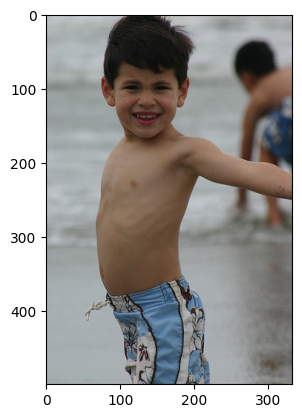

1/1 [==============================] - 0s 33ms/step
boy in swim trunks is running through water


In [29]:
# Generate the output

pic = list(encoding_test.keys())[1]
img = encoding_test[pic].reshape(1, 2048)
x = plt.imread(images + pic)
plt.imshow(x)
plt.show()
print(greedy_search(img, model))

In [ ]:
# Save the created model

model.save("final_model.h5")

In [ ]:
# Same the model weights

model.save_weights('final_modelWeights.h5')

In [25]:
# Recreate the exact same model, including its weights and the optimizer
reloaded_model = tf.keras.models.load_model('my_model_22.h5')

# Show the model architecture
reloaded_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 34)]         0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 2048)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, 34, 200)      330400      ['input_3[0][0]']                
                                                                                                  
 dropout (Dropout)              (None, 2048)         0           ['input_2[0][0]']                
                                                                                            

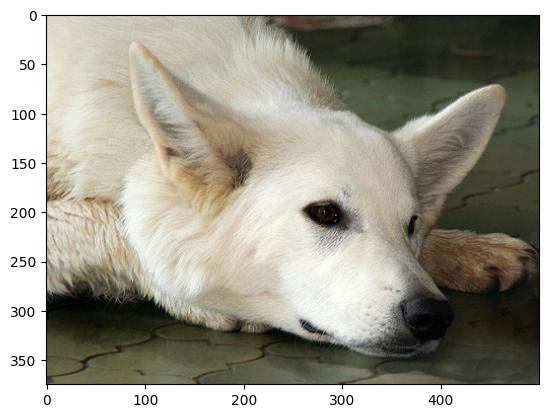

1/1 [==============================] - 0s 38ms/step
dog is running through the snow


In [30]:
# Generate the output

pic = list(encoding_test.keys())[3]
img = encoding_test[pic].reshape(1, 2048)
x = plt.imread(images + pic)
plt.imshow(x)
plt.show()
print(greedy_search(img, model))